# GAN creation

In [2]:
# For COLAB
# from google.colab import drive
# drive.mount('/content/gdrive')
# !pip install -q kaggle
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download xhlulu/140k-real-and-fake-faces
# ! unzip /content/140k-real-and-fake-faces.zip

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [20]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8278885833141555004
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1745302324
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17260067609111679329
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [21]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Dataset loading

In [22]:
from keras.preprocessing.image import ImageDataGenerator

In [23]:
BATCH_SIZE = 16
image_height = 64
image_width = 64
latent_features = 128
num_images = 1000

In [24]:
# Define the input and output directories
input_directory = 'real_vs_fake/real-vs-fake/train/'

# Create a dataset from the images
real_folder = os.path.join(input_directory, 'real')
image_paths = [os.path.join(real_folder, filename) for filename in os.listdir(real_folder)[:num_images]]

# Function to preprocess the image
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [image_height, image_width])
    img = tf.cast(img, tf.float32)
    img = (img - 127.5) / 127.5
    return img

# Create a dataset from the image paths
dataset = tf.data.Dataset.from_tensor_slices(image_paths)
dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.batch(BATCH_SIZE)

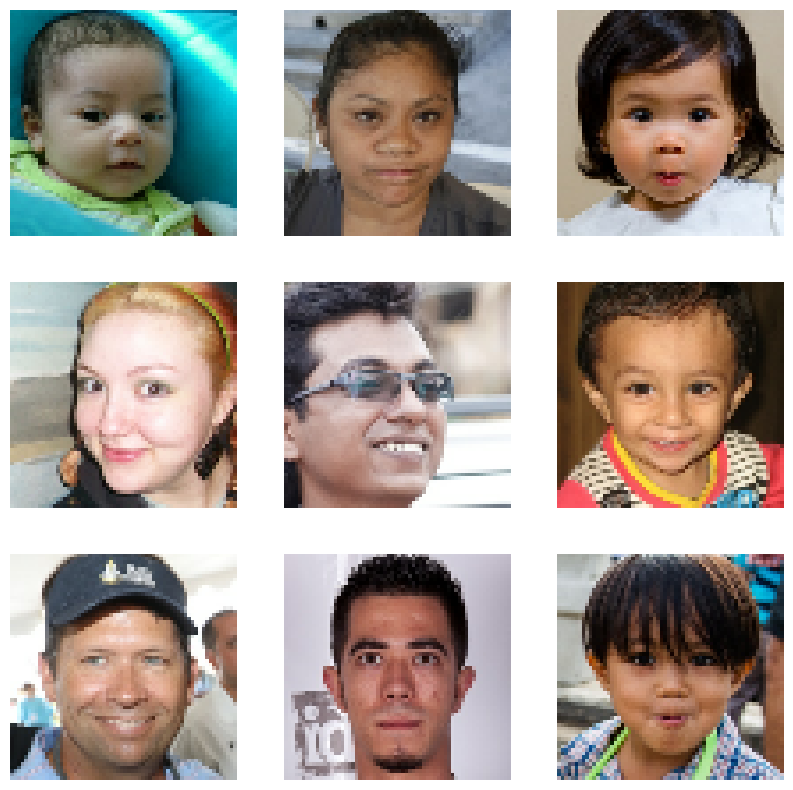

In [25]:
for batch in dataset.take(1):  # Take the first batch for display
    batch = (batch + 1) / 2
    plt.figure(figsize=(10, 10))
    for i in range(min(BATCH_SIZE, 9)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(batch[i].numpy())
        plt.axis("off")
    plt.show()

## GAN architecture

In [26]:
from keras.initializers import RandomNormal
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D, ReLU, Conv2DTranspose, BatchNormalization

In [27]:
def build_generator():
    init = RandomNormal(stddev=0.02)
    model = Sequential()

    # Beginnings of a generated image
    model.add(Dense(4*4*1024, input_dim=latent_features, kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Reshape((4,4,1024)))

    # Upsampling block
    model.add(UpSampling2D())
    model.add(Conv2D(512, 3, 1, padding='same', kernel_initializer=init))
    # model.add(Conv2DTranspose(512, 4, 2,padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    # Upsampling block
    model.add(UpSampling2D())
    model.add(Conv2D(256, 3, 1, padding='same', kernel_initializer=init))
    # model.add(Conv2DTranspose(256, 4, 2,padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    # Upsampling block
    model.add(UpSampling2D())
    model.add(Conv2D(128, 3, 1, padding='same', kernel_initializer=init))
    # model.add(Conv2DTranspose(256, 4, 2,padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    # model.add(Conv2DTranspose(128, 4, 2,padding='same', kernel_initializer=init))
    # model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))

    # Upsampling block
    model.add(UpSampling2D())
    model.add(Conv2D(3, 3, 1, padding='same', kernel_initializer=init, activation='tanh'))
    # model.add(Conv2DTranspose(3, 4, 2,padding='same', activation='tanh', kernel_initializer=init))

    return model

generator = build_generator()
generator.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 16384)             2113536   
                                                                 
 batch_normalization_18 (Bat  (None, 16384)            65536     
 chNormalization)                                                
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 16384)             0         
                                                                 
 reshape_10 (Reshape)        (None, 4, 4, 1024)        0         
                                                                 
 up_sampling2d_15 (UpSamplin  (None, 8, 8, 1024)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 8, 8, 512)       

1/1 [==============================] - 13s 13s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


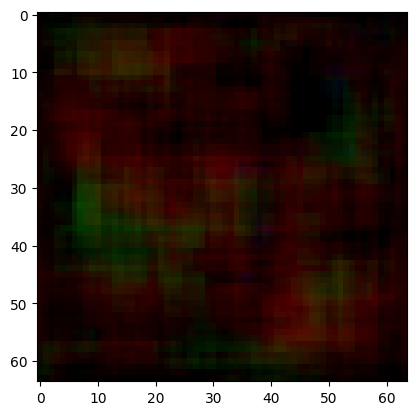

In [28]:
img = generator.predict(np.random.normal(size=(1, latent_features, 1)))
plt.imshow(img[0])

In [13]:
def build_discriminator():
    init = RandomNormal(stddev=0.02)
    model = Sequential()
    
    model.add(Conv2D(128, 4, 2, padding='same', input_shape = (image_width,image_height,3), kernel_initializer=init))
    model.add(LeakyReLU(0.2))
 
    model.add(Conv2D(256, 4, 2, padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(512, 4, 2, padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(1024, 4, 2, padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       6272      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 256)       524544    
                                                                 
 batch_normalization_4 (Batc  (None, 16, 16, 256)      1024      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 512)         2097664   
                                                      

In [14]:
img = generator.predict(np.random.normal(size=(4, latent_features, 1)))
discriminator.predict(img)

1/1 [==============================] - 0s 236ms/step


array([[0.49982333],
       [0.5005307 ],
       [0.49980465],
       [0.49978045]], dtype=float32)

## Training loop

In [38]:
from keras.models import load_model
generator = load_model('models\generator.h5')
discriminator = load_model('models\discriminator.h5')

In [39]:
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.utils import array_to_img
from keras.callbacks import Callback

In [40]:
g_opt = Adam(learning_rate=0.0002,beta_1=0.5)
d_opt = Adam(learning_rate=0.0002,beta_1=0.5)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [41]:
class GAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Get the data

        # Train the discriminator for real imgs
        with tf.GradientTape() as d_tape:
            real_images = batch
            ypred_real = self.discriminator(real_images, training=True)
            y_real = tf.ones_like(ypred_real)
            noise_real = -0.10*tf.random.uniform(tf.shape(ypred_real))
            y_real += noise_real
            real_d_loss = self.d_loss(y_real, ypred_real)
        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(real_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))


        # Train the discriminator for fake imgs
        with tf.GradientTape() as d_tape:
            fake_images = self.generator(tf.random.normal((BATCH_SIZE, latent_features, 1)), training=False)
            ypred_fake = self.discriminator(fake_images, training=True)
            y_fake = tf.zeros_like(ypred_fake)
            fake_d_loss = self.d_loss(y_fake, ypred_fake)
        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(fake_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            gen_images = self.generator(tf.random.normal((BATCH_SIZE,latent_features,1)), training=True)
            predicted_labels = self.discriminator(gen_images, training=False)
            total_g_loss = self.g_loss(tf.ones_like(predicted_labels), predicted_labels)
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss_real":real_d_loss,"d_loss_fake":fake_d_loss, "g_loss":total_g_loss}

In [42]:
gan = GAN(generator, discriminator)
gan.compile(g_opt, d_opt, g_loss, d_loss)

In [33]:
class ModelMonitor(Callback):
    def __init__(self, latent_dim=latent_features):
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            random_latent_vectors = tf.random.uniform((1, self.latent_dim,1))
            generated_images = self.model.generator(random_latent_vectors)
            generated_images = (generated_images + 1) / 2
            generated_images = generated_images.numpy()
            img = array_to_img(generated_images[0])
            # os.makedirs("/training/", exist_ok=True)
            img.save(f'training/{3000 + epoch}_generated_img.png')

## Training

In [34]:
hist = gan.fit(dataset, epochs=1000, callbacks=[ModelMonitor()])

Epoch 1/1000
16/16 [==============================] - 4s 278ms/step - d_loss_real: 0.1167 - d_loss_fake: 8.0286e-07 - g_loss: 0.0129
Epoch 2/1000
16/16 [==============================] - 4s 277ms/step - d_loss_real: 0.1181 - d_loss_fake: 3.6383e-07 - g_loss: 0.0149
Epoch 3/1000
16/16 [==============================] - 4s 273ms/step - d_loss_real: 0.1202 - d_loss_fake: 4.8885e-07 - g_loss: 0.0167
Epoch 4/1000
16/16 [==============================] - 4s 273ms/step - d_loss_real: 0.1174 - d_loss_fake: 6.0219e-07 - g_loss: 0.0160
Epoch 5/1000
16/16 [==============================] - 4s 272ms/step - d_loss_real: 0.1170 - d_loss_fake: 9.7100e-07 - g_loss: 0.0157
Epoch 6/1000
16/16 [==============================] - 4s 273ms/step - d_loss_real: 0.1180 - d_loss_fake: 8.5095e-07 - g_loss: 0.0139
Epoch 7/1000
16/16 [==============================] - 4s 273ms/step - d_loss_real: 0.1171 - d_loss_fake: 1.1591e-06 - g_loss: 0.0159
Epoch 8/1000
16/16 [==============================] - 4s 273ms/step -

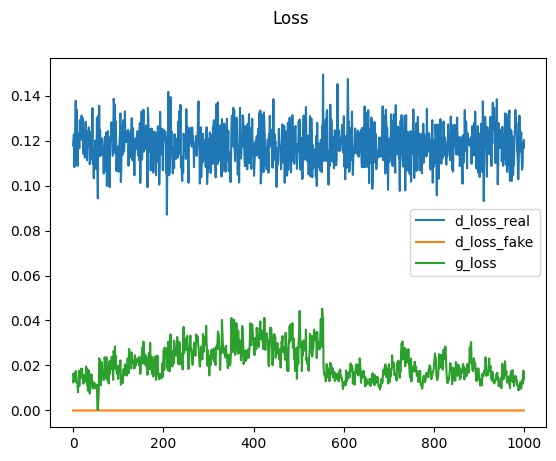

In [35]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss_real'], label='d_loss_real')
plt.plot(hist.history['d_loss_fake'], label='d_loss_fake')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

In [36]:
generator.save('models/generator.h5')
discriminator.save('models/discriminator.h5')

## Testing

1/1 [==============================] - 0s 123ms/step


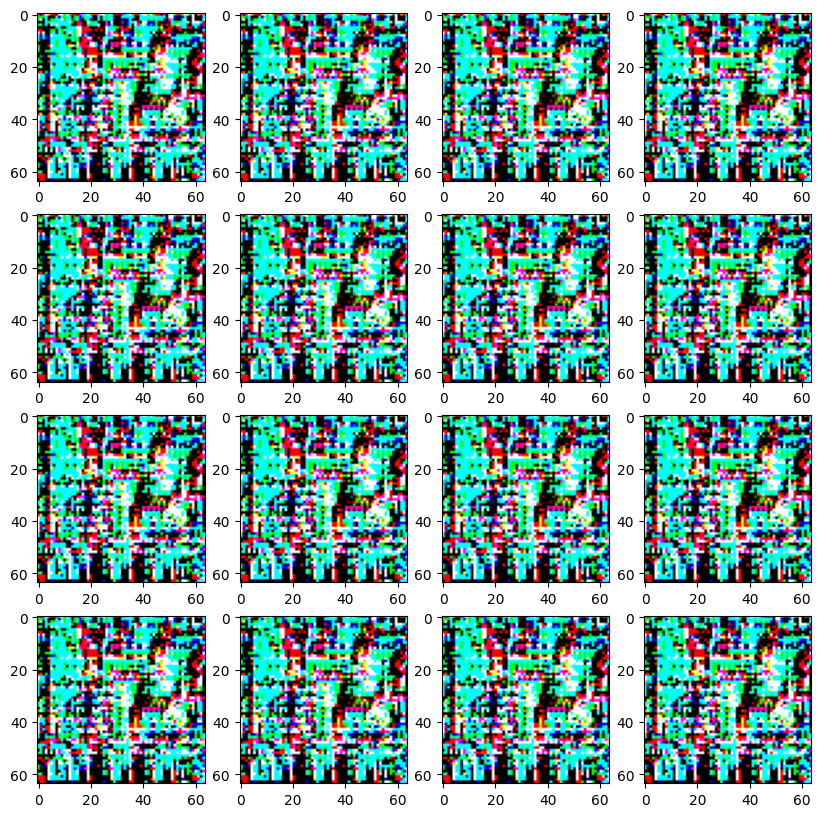

In [43]:
imgs = generator.predict(tf.random.normal((16, latent_features, 1)))
imgs = (imgs + 1) / 2
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])